In [1]:
from functools import partial
import warnings; warnings.filterwarnings("ignore")
import jax
import jax.numpy as jnp
from scipy.stats import moment

In [2]:
def P(n, x, xi, xi_):
    """
    Computes P_n(x) = sum_1^n(xi_i * cos(i * x) + xi'_i * sin(i * x))
    """
    i = jnp.arange(1, n + 1)
    x = x.reshape((-1, 1))
    return (xi * jnp.cos(i * x) + xi_ * jnp.sin(i * x)).sum(-1)

def N(n, seed, gaussian=True):
    """
    Computes the number of roots of P_n on the [0, 2pi] interval
    """
    num_intervals = 20 * n
    x = jnp.linspace(0, 2 * jnp.pi, num_intervals + 1)
    if gaussian:
        xi, xi_ = jax.random.normal(seed, shape=(2, n))
    else:
        xi, xi_ = jax.random.bernoulli(seed, shape=(2, n)) * 2 - 1
    P_x = P(n, x, xi, xi_)
    return ((P_x[:-1] > 0) ^ (P_x[1:] > 0)).sum()

In [3]:
records = []
for gaussian in [True, False]:
    group = "Gaussian" if gaussian else "Rademacher"
    print(f"=== {group} === ")
    for n in range(100, 1001, 100):
        # generate 10000 different random seeds (depend on n & gaussian)
        seeds = jax.random.split(jax.random.PRNGKey(n + gaussian), 10000)
        samples = jax.lax.map(partial(N, n, gaussian=gaussian), seeds)
        mean = samples.mean()
        var = samples.var(ddof=1)
        sigma = var ** 0.5
        m3 = moment(samples, moment=3) / (sigma ** 3).item()
        m4 = moment(samples, moment=4) / (sigma ** 4).item()
        m5 = moment(samples, moment=5) / (sigma ** 5).item()
        m6 = moment(samples, moment=6) / (sigma ** 6).item()
        c0 = mean.item() / n
        c1 = var.item() / n
        print("n={:>4}: {:.4f}, {:.4f}, {:>7.4f}, {:.4f}, {:>7.4f}, {:.4f}"
              .format(n, c0, c1, m3, m4, m5, m6))
        records.append({"group": group, "n": n, "c0": c0, "c1": c1,
                        "m3": m3, "m4": m4, "m5": m5, "m6": m6})

=== Gaussian === 
n= 100: 1.1626, 0.5561, -0.0156, 3.0568, -0.0820, 15.9937
n= 200: 1.1559, 0.5690,  0.0086, 2.8863,  0.1058, 13.1659
n= 300: 1.1564, 0.5705, -0.0314, 3.0312, -0.4158, 15.8530
n= 400: 1.1553, 0.5424, -0.0191, 2.9329, -0.1878, 13.8376
n= 500: 1.1553, 0.5479, -0.0257, 3.0932, -0.3471, 16.1721
n= 600: 1.1549, 0.5488,  0.0011, 3.0078, -0.0349, 15.4506
n= 700: 1.1552, 0.5622, -0.0236, 2.9778, -0.1688, 14.7706
n= 800: 1.1542, 0.5575, -0.0055, 2.9588,  0.0661, 14.6898
n= 900: 1.1542, 0.5608, -0.0065, 2.9896, -0.0889, 14.4924
n=1000: 1.1542, 0.5510,  0.0168, 3.0088,  0.2060, 15.0251
=== Rademacher === 
n= 100: 1.1634, 0.2892,  0.0191, 2.9998,  0.0317, 14.7930
n= 200: 1.1585, 0.2896, -0.0036, 2.9991,  0.1185, 15.5471
n= 300: 1.1568, 0.2933, -0.0606, 3.0842, -0.8200, 16.3366
n= 400: 1.1554, 0.2943, -0.0018, 2.9860, -0.1169, 14.5703
n= 500: 1.1548, 0.2940, -0.0277, 3.0083, -0.2826, 15.1006
n= 600: 1.1548, 0.2848, -0.0392, 3.0263, -0.4036, 15.5963
n= 700: 1.1546, 0.2960,  0.0434, 3

In [4]:
import pandas as pd

df = pd.DataFrame.from_records(records)
df

,group,n,c0,c1,m3,m4,m5,m6
0,Gaussian,100,1.162572,0.556130,-0.015614,3.056802,-0.082020,15.993669
1,Gaussian,200,1.155932,0.569019,0.008606,2.886257,0.105838,13.165854
2,Gaussian,300,1.156447,0.570499,-0.031418,3.031190,-0.415763,15.852991
3,Gaussian,400,1.155346,0.542426,-0.019076,2.932947,-0.187829,13.837582
4,Gaussian,500,1.155342,0.547866,-0.025681,3.093241,-0.347065,16.172056
5,Gaussian,600,1.154893,0.548771,0.001056,3.007821,-0.034909,15.450561
6,Gaussian,700,1.155228,0.562196,-0.023565,2.977797,-0.168825,14.770590
7,Gaussian,800,1.154170,0.557499,-0.005517,2.958765,0.066124,14.689809
8,Gaussian,900,1.154184,0.560786,-0.006512,2.989621,-0.088863,14.492350
9,Gaussian,1000,1.154198,0.550963,0.016768,3.008778,0.206043,15.025128


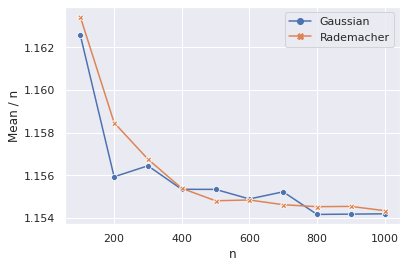

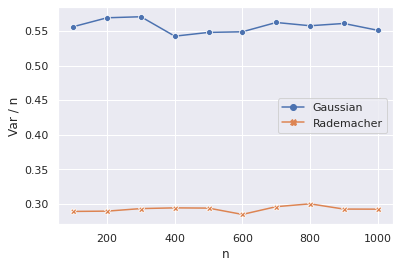

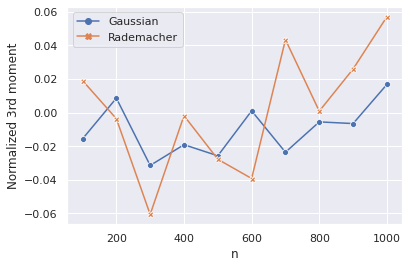

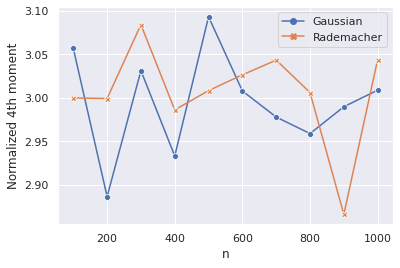

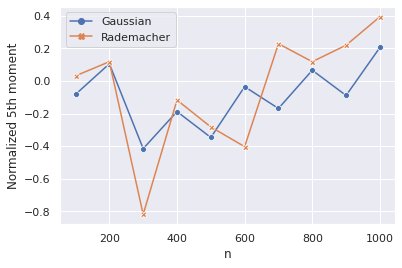

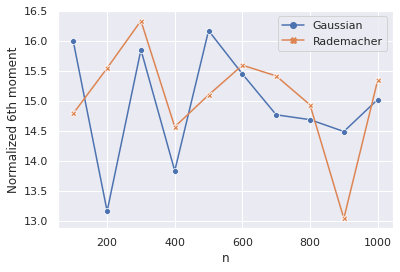

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

for y in ["c0", "c1", "m3", "m4", "m5", "m6"]:
    ax = sns.lineplot(data=df, x="n", y=y, hue="group", style="group", markers=True, dashes=False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    if y == "c0":
        ylabel = "Mean / n"
        yfile = "Mean per n"
    elif y == "c1":
        ylabel = "Var / n"
        yfile = "Var per n"
    elif y == "m3":
        yfile = ylabel = "Normalized 3rd moment"
    else:
        yfile = ylabel = "Normalized {}th moment".format(y[-1])
    ax.set_ylabel(ylabel)
    plt.savefig("{}.pdf".format("_".join(yfile.split(" "))), format="pdf", bbox_inches="tight")
    plt.show()